# Non-invasive Quantification of In-Vivo Glycated Hemoglobin Based on Photon Diffusion Theory and Genetic Symbolic Regression Models

This is the main code to process and compute the estimated glucated hemoglobin levels from three wavelength DVP signals. The DVP signals used here in this research are recorded using clip-type fingertip DVP signal recording device. The mathematical models derived using photon diffusion theory and glycated hemoglobin, considering the anatomy and blood composition, and tested with a limited number of volunteers' data.

## Dataset

For evaluating these mathematical models, 20 voluntary participants were taken. For each volunteer, the data taken were - 
    a) Finger width
    b) BMI
    c) 3 wavelength DVP data
    d) Reference invasive HbA1c data
    e) Reference SpO2 data

## Method

### Preprocessing

    a) DVP signal filtering:
        Recorded DVP signals were filtered with a 2nd order Butterworth filter. The critical frequency was set at 8Hz.
    b) Calculate Ratio
        I) Calculate R1-R2 for blood-only and whole-finger models.
        II) Remove NaN and Infs
        III) Select ratio values with 60% confidence interval

### Ratio calibration

The computed ratio values are first calibrated against reverse calculated R1-R2 values from reference HbA1c and SpO2 values. This calibration is done by XGBoost. Four XGBoost models are applied for blood-only R1 and R2, and whole-finger R1 and R2, respectively. The input for the XGBoost models are Finger Width, BMI, and computed R1-R2. The target of these models are reverse calculated R1-R2.

### Model estimation

Then calibrated ratios are fed into the mathematical model for computing uncalibrated hba1c and spo2 values. 

### Value calibration

In this step, the uncalibrated hba1c and spo2 values are calibrated with XGBoost models. Four models are implemented for calibrating hba1c and spo2 values for two respective mathematical models for transmission and reflection types. the input features are uncalibrated hba1c and spo2. The target values are respective to the model goals.

In [1]:
import numpy as np
from adjustText import adjust_text
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn import svm
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split,KFold
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
from scipy import stats
import xgboost as xgb

C:\ProgramData\Anaconda3\lib\site-packages\dask\dataframe\utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Load Dataset

In [26]:
#Fw,BMI

fdvp = './data/'
falias = ['0.csv','1.csv' ,'2.csv', '3.csv' ,'4.csv','5.csv', '6.csv' ,'7.csv' ,'8.csv' ,'9.csv','10.csv' ,'11.csv' ,'12.csv' ,'13.csv' ,'14.csv','15.csv' ,'16.csv' ,'17.csv' ,'18.csv' ,'19.csv']
datLab = [4.9, 5.7 ,5.9, 5.2, 6.2, 5.9, 5.7, 5.8, 8.8 ,8.2 ,5.9 ,5.4 ,5.8 ,9.1 ,5.9 ,6.4 ,6.1 ,6.1,5.5,5.9]
datspo2 = [97 ,96, 96, 99, 97, 97 ,95, 97, 95 ,96 ,97, 98, 95, 98, 97, 96, 98 ,97, 93 ,97]
age = [26, 27, 25, 28, 31, 27, 27, 25, 55, 55, 32, 26, 31, 55, 27, 26, 27, 27, 26, 29]
gen = ['F', 'M', 'M', 'F', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'F', 'M', 'M', 'M', 'F', 'M' ,'M','F', 'M']
fw = [1.1,1.3 ,1.4, 1.4 ,1.3 ,1.4, 1.3, 1.3, 1.5, 1.5, 1.1, 1.2, 1.3, 1.5 ,1.3 ,1.1, 1.2, 1.3,1.1, 1.3]
bmi = [28.8,31.9, 33.1, 27.0,  25.3, 32.2, 31.9, 21.6, 33.1 ,33.1, 25.9 ,27.6, 27.8, 33.1,31.9, 23.5, 24.4, 28.1, 24.0, 32.9]

In [27]:
fnam = []
for e in falias:
    fnam.append(fdvp+e)
print(len(fnam))

20


# Dataset Information

%HbA1c
Min:  4.9
Max:  9.1
Mean:  6.22
Median:  5.9
STD:  1.1025425161870175
Variance:  1.2155999999999998
25th percentile:  5.7
75th percentile:  6.124999999999999


%SpO2
Min:  95
Max:  99
Mean:  96.7
Median:  97.0
STD:  1.0535653752852738
Variance:  1.11
25th percentile:  96.0
75th percentile:  97.0


age:  31.6 +- 10.006997551713502
fw:  1.2950000000000002 +- 0.12835497652993433
bmi:  28.799999999999994 +- 3.829360259886761


Text(0, 0.5, 'Frequency')

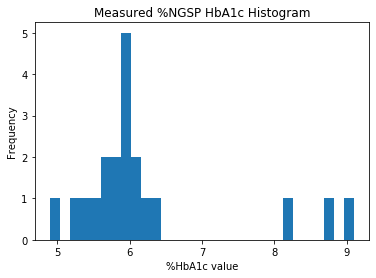

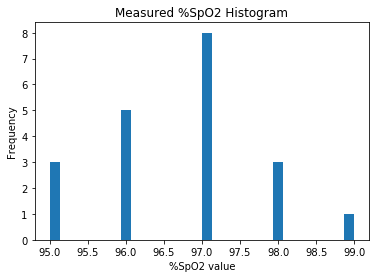

In [4]:
print('%HbA1c')
print('Min: ',np.amin(datLab))
print('Max: ',np.amax(datLab))
print('Mean: ',np.mean(datLab))
print('Median: ',np.median(datLab))
print('STD: ',np.std(datLab))
print('Variance: ',np.var(datLab))
print('25th percentile: ',np.percentile(datLab,25))
print('75th percentile: ',np.percentile(datLab,75))
print('\n')

print('%SpO2')
print('Min: ',np.amin(datspo2))
print('Max: ',np.amax(datspo2))
print('Mean: ',np.mean(datspo2))
print('Median: ',np.median(datspo2))
print('STD: ',np.std(datspo2))
print('Variance: ',np.var(datspo2))
print('25th percentile: ',np.percentile(datspo2,25))
print('75th percentile: ',np.percentile(datspo2,75))
print('\n')

print('age: ',np.mean(age),'+-',np.std(age))
print('fw: ',np.mean(fw),'+-',np.std(fw))
print('bmi: ',np.mean(bmi),'+-',np.std(bmi))

plt.hist(datLab,30)
plt.title('Measured %NGSP HbA1c Histogram')
plt.xlabel('%HbA1c value')
plt.ylabel('Frequency')

plt.figure()
plt.hist(datspo2,30)
plt.title('Measured %SpO2 Histogram')
plt.xlabel('%SpO2 value')
plt.ylabel('Frequency')

# Function Definitions

In [5]:
from matplotlib.patches import Circle, Wedge, Polygon, Path
from matplotlib.collections import PatchCollection

def EGA(ref,est):
    fig, ax = plt.subplots()

    polygons = []

    A = [[4.0,4.0],[5.7,4.0],[5.7,5.4],[7.2,6.5],[12.0,6.5],[12.0,12.0],[6.5,12.0],[6.5,7.2],[5.4,5.7],[4.0,5.7]]
    Bd = [[5.7,4.0],[5.7,5.4],[7.2,6.5],[12.0,6.5],[12.0,5.7],[6.5,5.7],[6.5,4.0]]
    Bu = [[4.0,5.7],[5.4,5.7],[6.5,7.2],[6.5,12.0],[5.7,12.0],[5.7,6.5],[4.0,6.5]]
    Cd = [[6.5,4.0],[6.5,5.7],[12.0,5.7],[12.0,4.0]]
    Cu = [[4.0,6.5],[5.7,6.5],[5.7,12.0],[4.0,12.0]]

#     print(np.asarray(A).shape)
    pA = Polygon(np.asarray(A),True)
    pBd = Polygon(np.asarray(Bd),True)
    pBu = Polygon(np.asarray(Bu),True)
    pCd = Polygon(np.asarray(Cd),True)
    pCu = Polygon(np.asarray(Cu),True)
    polygons.append(pA)
    polygons.append(pBd)
    polygons.append(pBu)
    polygons.append(pCd)
    polygons.append(pCu)


    p = PatchCollection(polygons)
    p.set_color([[0,1,0,0.3],[1,1,0,0.3],[1,1,0,0.3],[1,0,0,0.3],[1,0,0,0.3]])
    ax.add_collection(p)



    plt.plot([4.0,12.0],[4.0,12.0])


    x = ref
    y = est

    sA = []
    sB = []
    sC = []
    for i in range(len(y)):
        sA.append(int(pA.contains_point([x[i],y[i]]))*30)
        sB.append(int(pBd.contains_point([x[i],y[i]]) or pBu.contains_point([x[i],y[i]]))*30)
        sC.append(int(pCd.contains_point([x[i],y[i]]) or pCu.contains_point([x[i],y[i]]))*30)


    plt.scatter(x,y,s=sA,color=[0.227, 0.513, 0.282,1])
    plt.scatter(x,y,s=sB,color=[0.886, 0.654, 0.133,1])
    plt.scatter(x,y,s=sC,color=[0.941, 0, 0.098,1])

    lx = np.linspace(min(x), max(x), 100)
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(lx,p(lx))


    plt.text(10.5,9,'A',fontsize=26)
    plt.text(9,10.5,'A',fontsize=26)
    plt.text(10.5,5.94,'B',fontsize=26)
    plt.text(5.94,10.5,'B',fontsize=26)
    plt.text(10.5,4.7,'C',fontsize=26)
    plt.text(4.7,10.5,'C',fontsize=26)
    fig.set_figheight(8)
    fig.set_figwidth(8)
    plt.xlim([4.0,12.0])
    plt.ylim([4.0,12.0])
    plt.xlabel('HbA1c Invasive device (%NGSP)',fontsize=15)
    plt.ylabel('HbA1c Estimated (%NGSP)',fontsize=15)
    plt.title('Error Grid Analysis (EGA) for estimated %HbA1c values',fontsize=15)
    plt.show()

In [6]:
def Spo2Plot(ref,est):
    x = np.asarray(ref)
    y = np.asarray(est)
    plt.figure(figsize=(6,6))
    plt.scatter(x,y)
    plt.plot([90,100],[90,100])
    plt.xlim([90,100])
    plt.ylim([90,100])

    lx = np.linspace(min(x), max(x), 100)
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
#     plt.plot(lx,p(lx))

    plt.xlabel('Reference %SpO2 values',fontsize=12)
    plt.ylabel('Estimated %SpO2 values',fontsize=12)
    plt.title('Estimated and reference %SpO2 scatter plot',fontsize=12)

In [7]:
def evalMetricsH(ref,est):
    print('############ HbA1c Evaluation Metrics ############')
    CVy = np.asarray(est)
    CVx = np.asarray(ref)
    print('Diff STD (full) = ',np.std(CVx-CVy))
    print('MSE (full) = ',np.sum((CVx-CVy)**2)/CVy.shape[0])
    print('ME (full) = ',np.sum((CVx-CVy))/CVy.shape[0])
    print('MAD (full) = ',np.sum(np.abs(CVx-CVy))/CVy.shape[0])
    print('RMSE (full) = ',np.sqrt(np.sum((CVx-CVy)**2)/CVy.shape[0]))
    print('R2 score (full) = ',r2_score(CVx,CVy))
    print('Pearson R and p-value: ',pearsonr(CVx,CVy))
    print('#################################################\n')

In [8]:
def evalMetricsS(ref,est):
    print('############ SpO2 Evaluation Metrics ############')
    CVy = np.asarray(est)
    CVx = np.asarray(ref)
    print('Diff STD (full) = ',np.std(CVx-CVy))
    print('MSE (full) = ',np.sum((CVx-CVy)**2)/CVy.shape[0])
    print('ME (full) = ',np.sum((CVx-CVy))/CVy.shape[0])
    print('MAD (full) = ',np.sum(np.abs(CVx-CVy))/CVy.shape[0])
    print('RMSE (full) = ',np.sqrt(np.sum((CVx-CVy)**2)/CVy.shape[0]))
    print('Reference Closeness Factor (RCF): ', np.nanmean(1-np.abs(CVx-CVy)/100))
    print('#################################################\n')

In [9]:
def CVplotSp(ref,est,indx=1):
    ref = np.asarray(ref)
    texts = []
    CVy_std = []
    CVy_mean = []
    for i in range(len(est)):
        CVy_std.append(np.std(est[i][indx]))
        CVy_mean.append(np.mean(est[i][indx]))
    
    plt.figure()
    plt.scatter(ref,np.asarray(CVy_std)/np.asarray(CVy_mean)*100)
    print('Maximum %CV: ',np.amax(np.asarray(CVy_std)/np.asarray(CVy_mean)*100))
    print('Mean %CV: ',np.nanmean(np.asarray(CVy_std)/np.asarray(CVy_mean)*100))
    plt.hlines(np.nanmean(np.asarray(CVy_std)/np.asarray(CVy_mean)*100),np.amin(ref),np.amax(ref),linestyles='dashdot')


    texts.append(plt.text(95.2,np.mean(np.asarray(CVy_std)/np.asarray(CVy_mean)*100)+0.01,'Mean (%) = '+ '%.2f' % np.nanmean(np.asarray(CVy_std)/np.asarray(CVy_mean)*100)))
    
    plt.xlabel('Reference SpO2 value (%)',fontsize=12)
    plt.ylabel('Coefficient of Variation (%CV)',fontsize=12)
    plt.title('%CV measure for the individual volunteers data',fontsize=12)
    adjust_text(texts)
    print('\n')

In [10]:
def CVplotHb(ref,est,indx=1):
    ref = np.asarray(ref)
    texts = []
    CVy_std = []
    CVy_mean = []
    for i in range(len(est)):
        CVy_std.append(np.std(est[i][indx]))
        CVy_mean.append(np.mean(est[i][indx]))

    plt.figure()
    plt.scatter(ref,np.asarray(CVy_std)/np.asarray(CVy_mean)*100)
    print('Maximum %CV: ',np.amax(np.asarray(CVy_std)/np.asarray(CVy_mean)*100))
    print('Mean %CV: ',np.nanmean(np.asarray(CVy_std)/np.asarray(CVy_mean)*100))
    plt.hlines(np.nanmean(np.asarray(CVy_std)/np.asarray(CVy_mean)*100),np.amin(ref),np.amax(ref),linestyles='dashdot')


    texts.append(plt.text(6.5,np.mean(np.asarray(CVy_std)/np.asarray(CVy_mean)*100)+0.01,'Mean (%) = '+ '%.2f' % np.nanmean(np.asarray(CVy_std)/np.asarray(CVy_mean)*100)))
    plt.xlabel('Reference HbA1c value (%NGSP)',fontsize=12)
    plt.ylabel('Coefficient of Variation (%CV)',fontsize=12)
    plt.title('%CV measure for the individual volunteers data',fontsize=12)
    adjust_text(texts)
    print('\n')

In [11]:
def spBAA(ref,est,xp=94):
    texts = []
    x = []
    y = []
    for i in range(len(ref)):
        m = est[i]
        o = ref[i]
        x.append((o+m)/2)
        y.append(o-m)

    plt.figure()
    plt.hlines(0.00,np.amin(x),np.amax(x),linestyles='solid')
    plt.hlines(np.mean(y)+1.96*np.std(y),np.amin(x),np.amax(x),linestyles='dotted')
    plt.hlines(np.mean(y)-1.96*np.std(y),np.amin(x),np.amax(x),linestyles='dotted')
    plt.hlines(np.mean(y),np.amin(x),np.amax(x),linestyles='dashdot')

    
    print('Mean: ',np.mean(y))
    print('+1.96 STD: ',np.mean(y)+1.96*np.std(y))
    print('-1.96 STD: ',np.mean(y)-1.96*np.std(y))
    print('Bias: ',np.mean(y),'+-',1.96*np.std(y))

    texts.append(plt.text(xp,np.mean(y)+1.96*np.std(y),'Mean+1.96 STD = %0.2f' % (np.mean(y)+1.96*np.std(y))))
#     texts.append(plt.text(xp,np.mean(y)+1.96*np.std(y),'%0.2f' % (np.mean(y)+1.96*np.std(y))))
    texts.append(plt.text(xp,np.mean(y)-1.96*np.std(y),'Mean-1.96 STD = %0.2f' % (np.mean(y)-1.96*np.std(y))))
#     texts.append(plt.text(xp,np.mean(y)-1.96*np.std(y),'%0.2f' % (np.mean(y)-1.96*np.std(y))))
    texts.append(plt.text(xp,np.mean(y),'Mean = '+ '%.2f' % np.mean(y)))

    plt.scatter(x,y)
    plt.xlabel('(Ref SpO2 + DVP SpO2)/2 (%)',fontsize=12)
    plt.ylabel('Ref SpO2 - DVP SpO2 (%)',fontsize=12)
    plt.title('Bland Altman analysis of %SpO2 estimations',fontsize=12)
    print('\n')
    adjust_text(texts,only_move={'points':'y', 'text':'y'})

In [12]:
def hBAA(ref,est,xp=7):
    texts = []
    x = []
    y = []
    for i in range(len(datLab)):
        m = est[i]
        o = ref[i]
        x.append((o+m)/2)
        y.append(o-m)

    plt.figure()
    plt.hlines(0.00,np.amin(x),np.amax(x),linestyles='solid')
    plt.hlines(np.mean(y)+1.96*np.std(y),np.amin(x),np.amax(x),linestyles='dotted')
    plt.hlines(np.mean(y)-1.96*np.std(y),np.amin(x),np.amax(x),linestyles='dotted')
    plt.hlines(np.mean(y),np.amin(x),np.amax(x),linestyles='dashdot')

    print('Mean: ',np.mean(y))
    print('+1.96 STD: ',np.mean(y)+1.96*np.std(y))
    print('-1.96 STD: ',np.mean(y)-1.96*np.std(y))
    print('Bias: ',np.mean(y),'+-',1.96*np.std(y))

    texts.append(plt.text(xp,np.mean(y)+1.96*np.std(y),'Mean+1.96 STD = %0.2f' % (np.mean(y)+1.96*np.std(y))))
#     texts.append(plt.text(xp,np.mean(y)+1.96*np.std(y),'%0.2f' % (np.mean(y)+1.96*np.std(y))))
    texts.append(plt.text(xp,np.mean(y)-1.96*np.std(y),'Mean-1.96 STD = %0.2f' % (np.mean(y)-1.96*np.std(y))))
#     texts.append(plt.text(xp,np.mean(y)-1.96*np.std(y),'%0.2f' % (np.mean(y)-1.96*np.std(y))))
    texts.append(plt.text(xp,np.mean(y),'Mean = '+ '%.2f' % np.mean(y)))

    plt.scatter(x,y)

    plt.xlabel('(Ref HbA1c + DVP HbA1c)/2 (%)',fontsize=12)
    plt.ylabel('Ref HbA1c - DVP HbA1c (%)',fontsize=12)
    plt.title('Bland Altman analysis of %NGSP HbA1c estimations',fontsize=12)
    print('\n')
    adjust_text(texts,only_move={'points':'y', 'text':'y'})

In [13]:
def h_pd_t_all(r1,r2,t=None):
    return (6.15936335534888*1.27304286165866/((1.40372070528354-(1.68441816236284*r2+1.87454858059168*r1/(2.80627484462903/(-1.26163478085074*r1))))*-0.99548712435394)*-0.0343802879846601+0.00537806616139937)
def sp_pd_t_all(r1,r2,t=None):
    return (((0.251643121877064+1.31847075684083*r1/(0.46265269097264*r2))-0.861598617089148*(0.336575137416501*(0.754064766997052*r1/(1.18191080790765*r2)+(1.21561985948609*r2/(1.38988208697395*r1)-1.5964877475478))/(31.8988447353337)/(-0.0214956792420726)/((-2.4036231081381+(1.25804125640654*r1-0.0859133752906778*r2))/(2.05959872995846*r2*6.15334062514677)/(-0.151308574121018))+1.33173427090979*r1/(0.422955397798822*r2)))*-3.2535479686123+2.1812449587768)

In [14]:
def h_pd_r_all(r1,r2,t=None):
    return (91.0447808941854/(np.log(0.472848927337199*r1))/(555.338734444868)*0.41016086982204-0.036448429839713)
def sp_pd_r_all(r1,r2,t=None):
    return ((2.70421181002984+((((0.396186552232621*r2-0.510573169464413*r1)*-28.8977328497528/((1.84655032200986*r1-1.84655050956127*r1))-(-13.4449494384318/(-0.557787505912751*r1)*-1.85836618050929+(-0.709047188595016*r2--12.5974709608637))*-0.860533431722578/((4.83333765235003e-05*r2-5.6431241658275e-05*r1)))*((0.216491803561878*r2+(0.509033056478345*r2-14.8760363469317))+(6.06283181259627*0.757788523591849*r2/(1.98579930279733*r1)/((0.686707810459551*r2-0.347056269527548*r1))-(1.19742333345485*r2-13.7298446101505)))+0.241391776034303)-(2.13078302383498*r2/(1.13374930693104e-05*r1)*2.41716430920269*r1*-13.0113806852521+46.7345478812483)))/((1.09087865479317*r1-0.738427493683826*r2))*3.68969948028274e-08-1.06067521233174)

In [15]:
def PDTr1F(h,s):
    return 1.29337810837817*((1.51332732*h + 0.0594136*s*(h - 1) + 30.982956935)*(4.53998196*h + 0.1782408*s*(h - 1) + 0.905099205))**1.0*((3.90469158*h + 0.0398884*s*(h - 1) + 40.391310075)*(11.71407474*h + 0.1196652*s*(h - 1) + 2.126531025))**(-1.0)*(((3.90469158*h + 0.0398884*s*(h - 1) + 40.391310075)*(11.71407474*h + 0.1196652*s*(h - 1) + 2.126531025))**0.5 - 1)*(976.6715*h + 9.9721*s*(h - 1) + 81.7926)/((((1.51332732*h + 0.0594136*s*(h - 1) + 30.982956935)*(4.53998196*h + 0.1782408*s*(h - 1) + 0.905099205))**0.5 - 1)*(379.0745*h + 14.8534*s*(h - 1) + 17.566))    #SEN

def PDTr2F(h,s):
    return 1.65055614474625*((1.51332732*h + 0.0594136*s*(h - 1) + 30.982956935)*(4.53998196*h + 0.1782408*s*(h - 1) + 0.905099205))**1.0*((4.94241914*h - 0.1836148*s*(h - 1) + 51.3693104605)*(14.82725742*h - 0.5508444*s*(h - 1) + 2.1845185815))**(-1.0)*(((4.94241914*h - 0.1836148*s*(h - 1) + 51.3693104605)*(14.82725742*h - 0.5508444*s*(h - 1) + 2.1845185815))**0.5 - 1)*(1233.3096*h - 45.9037*s*(h - 1) + 43.4921)/((((1.51332732*h + 0.0594136*s*(h - 1) + 30.982956935)*(4.53998196*h + 0.1782408*s*(h - 1) + 0.905099205))**0.5 - 1)*(379.0745*h + 14.8534*s*(h - 1) + 17.566))    #SEN

def PDRr1F(h,s):
    return 1.29337810837817*(0.2*((1.51332732*h + 0.0594136*s*(h - 1) + 30.982956935)*(4.53998196*h + 0.1782408*s*(h - 1) + 0.905099205))**0.5 + 1.0)*(976.6715*h + 9.9721*s*(h - 1) + 81.7926)/((0.2*((3.90469158*h + 0.0398884*s*(h - 1) + 40.391310075)*(11.71407474*h + 0.1196652*s*(h - 1) + 2.126531025))**0.5 + 1)*(379.0745*h + 14.8534*s*(h - 1) + 17.566))    #SEN

def PDRr2F(h,s):
    return 1.65055614474625*(0.2*((1.51332732*h + 0.0594136*s*(h - 1) + 30.982956935)*(4.53998196*h + 0.1782408*s*(h - 1) + 0.905099205))**0.5 + 1.0)*(1233.3096*h - 45.9037*s*(h - 1) + 43.4921)/((0.2*((4.94241914*h - 0.1836148*s*(h - 1) + 51.3693104605)*(14.82725742*h - 0.5508444*s*(h - 1) + 2.1845185815))**0.5 + 1)*(379.0745*h + 14.8534*s*(h - 1) + 17.566))    #SEN

# Leave One Out Cross Validation (LOOCV)

### Calculate R1-R2 data

In [16]:
from scipy import signal
def rprocfunc(filename,FS=32,TrRf=True,mode=1,HR = None):
    
    #mode = 1 transmission
    #mode = 0 reflection
    
    
    sos = signal.butter(2, 8, fs=FS, output='sos')
    
    datin = np.loadtxt(filename,delimiter=',')
    dat = []
    if (TrRf):
        for ds in datin:
            if ds[19] == mode:
                dat.append(ds)
        dat = np.array(dat)       
    else:
        dat = datin 

    if HR == None:
        flen = 2*FS*60/50
    else:
        flen = 2*FS*60/HR
    
    
    dat = np.asarray(dat)
    
    s_msks = []
    s_acs = []
    s_dcs = []
    s_logs = []
    
    for s_i in range(3):
        s = dat[:,s_i]
        fil_s = signal.sosfilt(sos, s)

#         plt.plot(fil_s)


        fr_s = int(0)
        fr_e = int(fr_s+flen)

        p_pos = []
        v_pos = []
        while fr_e <= len(fil_s):
            mxval = fr_s+np.argmax(fil_s[fr_s:fr_e])
            mnval = fr_s+np.argmin(fil_s[fr_s:fr_e])
            p_pos.append([mxval,fil_s[mxval]])
            v_pos.append([mnval,fil_s[mnval]])
            fr_s += int(flen/3)
            fr_e += int(flen/3)


        p_pos = np.asarray(p_pos)
        v_pos = np.asarray(v_pos)

        p_u = np.unique(p_pos[:,0],return_index=True)
        v_u = np.unique(v_pos[:,0],return_index=True)

        pu_pos = p_pos[p_u[1]]
        vu_pos = v_pos[v_u[1]]

#         plt.scatter(pu_pos[:,0],pu_pos[:,1],c='g')
#         plt.scatter(vu_pos[:,0],vu_pos[:,1],c='r')


        dedg = []
        for i in range(len(pu_pos)):
            dedg.append([pu_pos[i,0],pu_pos[i,1],1])
        for i in range(len(vu_pos)):
            dedg.append([vu_pos[i,0],vu_pos[i,1],0])
        dedg = np.asarray(dedg)
        dedg = dedg[dedg[:,0].argsort()]
#         print(dedg)


        s_mask = np.zeros(len(fil_s),dtype=bool)
        s_ac = np.zeros(len(fil_s))
        s_dc = np.zeros(len(fil_s))
        s_log = np.zeros(len(fil_s))

        fg = 0
        pval = 0
        ppos = int(0)
        for i in range(len(dedg)):
            if i == 0:
                fg = dedg[i,2]
                pval = dedg[i,1]
                ppos = int(dedg[i,0])
            else:
                if (fg == 0 and dedg[i,2] == 1) or (fg == 1 and dedg[i,2] == 0):
                    tpos = int(dedg[i,0])
                    tval = dedg[i,1]
                    s_mask[ppos:tpos] = True
                    s_ac[ppos:tpos] = abs(pval-tval)
                    s_dc[ppos:tpos] = min(pval,tval)
                    s_log[ppos:tpos] = abs(np.log10(pval/tval))

                    ppos = tpos
                    pval = tval
                    fg = dedg[i,2]
                else:
                    ppos = int(dedg[i,0])
                    pval = dedg[i,1]
                    fg = dedg[i,2]

        s_msks.append(s_mask)
        s_acs.append(s_ac)
        s_dcs.append(s_dc)
        s_logs.append(s_log)
#         print(s_mask)
#         print(s_ac)
#         print(s_dc)

    t_msks = np.logical_and(np.logical_and(s_msks[0],s_msks[1]),s_msks[2])
    
    b_ac = s_acs[0][t_msks]
    g_ac = s_acs[1][t_msks]
    r_ac = s_acs[2][t_msks]
    
    b_dc = s_dcs[0][t_msks]
    g_dc = s_dcs[1][t_msks]
    r_dc = s_dcs[2][t_msks]
    
    b_log = s_logs[0][t_msks]
    g_log = s_logs[1][t_msks]
    r_log = s_logs[2][t_msks]
    
    r1 = (g_ac/g_dc)/(r_ac/r_dc)
    r2 = (b_ac/b_dc)/(r_ac/r_dc)
    
    r1l = g_log/r_log
    r2l = b_log/r_log
    
#     return [r1,r2,r1l,r2l,s_acs,s_dcs,s_logs]
    return [r1,r2,r1l,r2l,[b_ac,g_ac,r_ac],[b_dc,g_dc,r_dc],[b_log,g_log,r_log]]

In [17]:
dat = []
rdat = []

for fn in fnam:
    print(fn)
    dat.append(rprocfunc(fn,HR=80))
    rdat.append(rprocfunc(fn,HR=80,mode=0))
    

./data/2/lab_9.csv
./data/3/lab_0.csv
./data/3/lab_3.csv


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:97: RuntimeWarning: invalid value encountered in log10


./data/2/lab_7.csv
./data/2/lab_10.csv
./data/2/lab_4.csv
./data/3/lab_5.csv


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:97: RuntimeWarning: divide by zero encountered in log10
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:129: RuntimeWarning: divide by zero encountered in true_divide
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:130: RuntimeWarning: divide by zero encountered in true_divide


./data/2/lab_5.csv
./data/3/lab_13.csv
./data/3/lab_19.csv
./data/3/lab_12.csv
./data/2/lab_11.csv
./data/3/lab_2.csv
./data/3/lab_18.csv
./data/2/lab_0.csv
./data/3/lab_11.csv
./data/2/lab_2.csv
./data/3/lab_4.csv
./data/3/lab_17.csv
./data/2/lab_6.csv


### R1-R2 Data Artifact removal
Checked for NaN, Inf data points. And 60% confidence interval data were taken

In [18]:
# plt.plot(dat[6][3][1])
# print(np.percentile(np.asarray(dat[6][3][1])[:,1:],10))
datr = []
datrl = []
hl = 80
ll = 20


for i in range(len(dat)):
#     pn = i

#     g = np.asarray(dat[pn][3][1])
#     b = np.asarray(dat[pn][3][0])
#     r = np.asarray(dat[pn][3][2])
#     r1 = []
#     r2 = []
    
#     for j in range(len(g)):
#         r1t = ((g[j,1]-g[j,2])/g[j,2])/((r[j,1]-r[j,2])/r[j,2])
#         r2t = ((b[j,1]-b[j,2])/b[j,2])/((r[j,1]-r[j,2])/r[j,2])
        
#         r1.append(r1t)
#         r2.append(r2t)
    
#     r1 = np.asarray(r1)
#     r2 = np.asarray(r2)
    
    r1 = dat[i][0]
    r2 = dat[i][1]
    
    nns_r1 = np.logical_not(np.isnan(r1))
    nfs_r1 = np.logical_not(np.isinf(r1))
    sel_r1 = (np.logical_and(nns_r1,nfs_r1))

    nns_r2 = np.logical_not(np.isnan(r2))
    nfs_r2 = np.logical_not(np.isinf(r2))
    sel_r2 = (np.logical_and(nns_r2,nfs_r2))

    rt_sel = np.logical_and(sel_r1,sel_r2)

    rt1_sel = r1[rt_sel]
    rt2_sel = r2[rt_sel]

    pr1_sel = np.logical_and(rt1_sel < np.percentile(rt1_sel,hl), rt1_sel > np.percentile(rt1_sel,ll))
    pr2_sel = np.logical_and(rt2_sel < np.percentile(rt2_sel,hl), rt2_sel > np.percentile(rt2_sel,ll))

    prt_sel = np.logical_and(pr1_sel,pr2_sel)

    r1f = rt1_sel[prt_sel]
    r2f = rt2_sel[prt_sel]
    
    
    
    r1 = rdat[i][0]
    r2 = rdat[i][1]
    
    nns_r1 = np.logical_not(np.isnan(r1))
    nfs_r1 = np.logical_not(np.isinf(r1))
    sel_r1 = (np.logical_and(nns_r1,nfs_r1))

    nns_r2 = np.logical_not(np.isnan(r2))
    nfs_r2 = np.logical_not(np.isinf(r2))
    sel_r2 = (np.logical_and(nns_r2,nfs_r2))

    rt_sel = np.logical_and(sel_r1,sel_r2)

    rt1_sel = r1[rt_sel]
    rt2_sel = r2[rt_sel]

    pr1_sel = np.logical_and(rt1_sel < np.percentile(rt1_sel,hl), rt1_sel > np.percentile(rt1_sel,ll))
    pr2_sel = np.logical_and(rt2_sel < np.percentile(rt2_sel,hl), rt2_sel > np.percentile(rt2_sel,ll))

    prt_sel = np.logical_and(pr1_sel,pr2_sel)

    r1lf = rt1_sel[prt_sel]
    r2lf = rt2_sel[prt_sel]
    
    datr.append([r1f,r2f])
    datrl.append([r1lf,r2lf])
    

In [19]:
#save block
import csv

fields = ['R1','R2','HbA1c','SpO2','Age','Gender','Finger width','BMI']
rms = []
rmsr = []
for i in range(len(datr)):
    rms.append([np.nanmean(datr[i][0]),np.nanmean(datr[i][1]),datLab[i],datspo2[i],age[i],gen[i],fw[i],bmi[i]])
    rmsr.append([np.nanmean(datrl[i][0]),np.nanmean(datrl[i][1]),datLab[i],datspo2[i],age[i],gen[i],fw[i],bmi[i]])

with open('SEN_reflec.csv', 'w') as f: 
    write = csv.writer(f) 
      
    write.writerow(fields) 
    write.writerows(rmsr)
    
with open('SEN_trans.csv', 'w') as f: 
    write = csv.writer(f) 
      
    write.writerow(fields) 
    write.writerows(rms)

In [20]:
def calcFeatImp(featImp):
    f0 = featImp['f0']
    f1 = featImp['f1']
#     f2 = featImp['f2']
#     f3 = featImp['f3']
    tot = f0+f1
    return [f0/tot,f1/tot]


lFw = np.asarray(fw) == -1
lBmi = np.asarray(bmi) == -1
lSel = np.logical_and(np.logical_not(lFw),np.logical_not(lBmi))
selFw = np.asarray(fw)[lSel]
selBmi = np.asarray(bmi)[lSel]
lIndx = np.arange(len(datr))[lSel]
print(lIndx)

kf = KFold(n_splits=len(selFw),shuffle=True,random_state=42)

results = []
resultsR = []
resultsE = []

rawdatrc = []
rawdatrlc = []
feat_imp = []

cnt = 1

for T,V in kf.split(lIndx):
    print(cnt,': ')
    cnt += 1
    print(lIndx[T],lIndx[V])
    
    trIndx = lIndx[T]
    trDatX = []
    trDatXm = []
    trDatY = []
    trDatYm = []
    
    
    for i in range(len(trIndx)):
        pn = trIndx[i]
        er1 = PDRr1F(datLab[pn]/100,datspo2[pn]/100)
        er2 = PDRr2F(datLab[pn]/100,datspo2[pn]/100)
        er1m = PDTr1F(datLab[pn]/100,datspo2[pn]/100)
        er2m = PDTr2F(datLab[pn]/100,datspo2[pn]/100)
        for j in range(len(datrl[pn][0])):
            trDatX.append([datrl[pn][0][j],datrl[pn][1][j],fw[pn],bmi[pn]]) #,fw[pn]
            trDatY.append([er1,er2])
        for j in range(len(datr[pn][0])):
            trDatXm.append([datr[pn][0][j],datr[pn][1][j],fw[pn],bmi[pn]])
            trDatYm.append([er1m,er2m])
    
    trDatX = np.asarray(trDatX)
    trDatXm = np.asarray(trDatXm)
    trDatY = np.asarray(trDatY)
    trDatYm = np.asarray(trDatYm)
    
    
    R1M = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)
    R2M = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)
    R1Mm = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)
    R2Mm = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)
    
    R1M.fit(trDatX[:,0:4],trDatY[:,0])
    R2M.fit(trDatX[:,0:4],trDatY[:,1])
    R1Mm.fit(trDatXm[:,0:4],trDatYm[:,0])
    R2Mm.fit(trDatXm[:,0:4],trDatYm[:,1])
    
    feat_im = []
    feat_im.append(calcFeatImp(R1M.get_booster().get_score(importance_type='gain')))
    feat_im.append(calcFeatImp(R2M.get_booster().get_score(importance_type='gain')))
    feat_im.append(calcFeatImp(R1Mm.get_booster().get_score(importance_type='gain')))
    feat_im.append(calcFeatImp(R2Mm.get_booster().get_score(importance_type='gain')))
    feat_imp.append(feat_im)
    
    print('Evaluating...')
    tsDatX = []
    tsDatXm = []
    
    pn = lIndx[V][0]
#     print(pn)
    for j in range(len(datrl[pn][0])):
        tsDatX.append([datrl[pn][0][j],datrl[pn][1][j],fw[pn],bmi[pn]])
    for j in range(len(datr[pn][0])):
        tsDatXm.append([datr[pn][0][j],datr[pn][1][j],fw[pn],bmi[pn]])
        
    tsDatX = np.asarray(tsDatX)
    tsDatXm = np.asarray(tsDatXm)
    
    pR1M = R1M.predict(tsDatX[:,0:4])
    pR2M = R2M.predict(tsDatX[:,0:4])
    pR1Mm = R1Mm.predict(tsDatXm[:,0:4])
    pR2Mm = R2Mm.predict(tsDatXm[:,0:4])
    
    er1 = PDRr1F(datLab[pn]/100,datspo2[pn]/100)
    er2 = PDRr2F(datLab[pn]/100,datspo2[pn]/100)
    er1m = PDTr1F(datLab[pn]/100,datspo2[pn]/100)
    er2m = PDTr2F(datLab[pn]/100,datspo2[pn]/100)
    
    resultsR.append([np.nanmean(datrl[pn][0]),np.nanmean(datrl[pn][1]),np.nanmean(datr[pn][0]),np.nanmean(datr[pn][1])])
    results.append([np.nanmean(pR1M),np.nanmean(pR2M),np.nanmean(pR1Mm),np.nanmean(pR2Mm)])
    resultsE.append([er1,er2,er1m,er2m,datLab[pn],datspo2[pn],pn])
    rawdatrc.append([pn,pR1M,pR2M])
    rawdatrlc.append([pn,pR1Mm,pR2Mm])

results = np.asarray(results)
resultsR = np.asarray(resultsR)
resultsE = np.asarray(resultsE)
feat_imp = np.asarray(feat_imp)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
1 : 
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] [0]


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Evaluating...
2 : 
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 18 19] [17]
Evaluating...
3 : 
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 16 17 18 19] [15]
Evaluating...
4 : 
[ 0  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] [1]
Evaluating...
5 : 
[ 0  1  2  3  4  5  6  7  9 10 11 12 13 14 15 16 17 18 19] [8]
Evaluating...
6 : 
[ 0  1  2  3  4  6  7  8  9 10 11 12 13 14 15 16 17 18 19] [5]
Evaluating...
7 : 
[ 0  1  2  3  4  5  6  7  8  9 10 12 13 14 15 16 17 18 19] [11]
Evaluating...
8 : 
[ 0  1  2  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] [3]
Evaluating...
9 : 
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 19] [18]
Evaluating...
10 : 
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 17 18 19] [16]
Evaluating...
11 : 
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 14 15 16 17 18 19] [13]
Evaluating...
12 : 
[ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] [2]
Evaluating...
13 : 
[ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19] [9]
Evalua

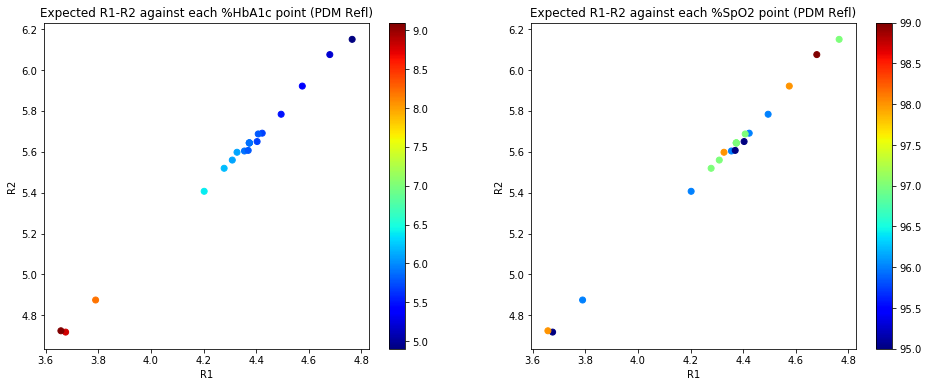

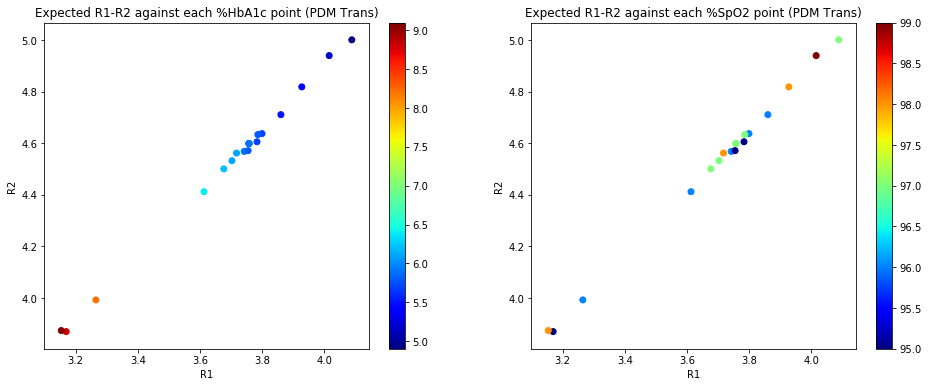

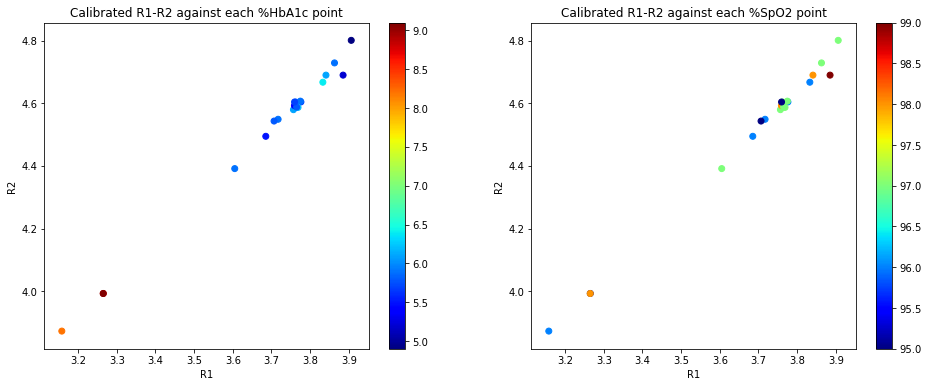

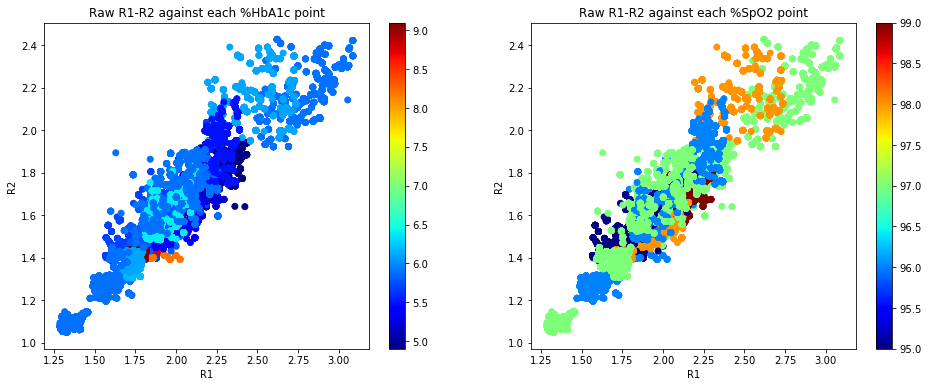

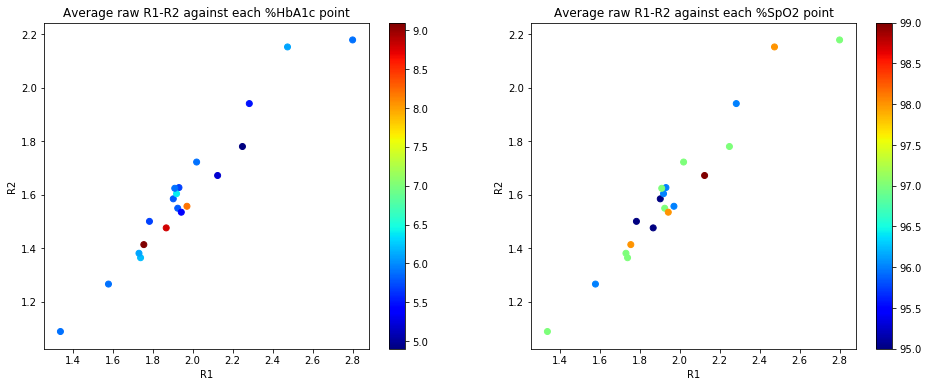

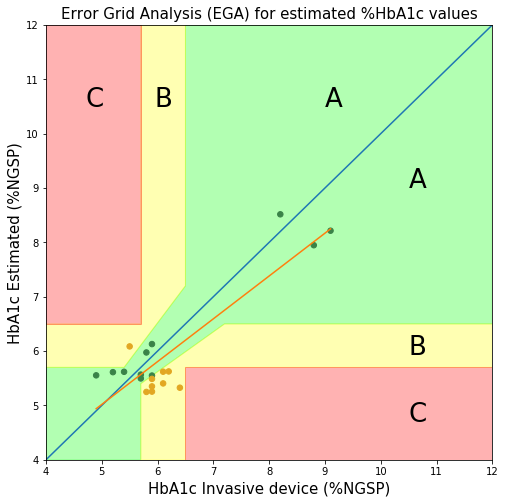

############ HbA1c Evaluation Metrics ############
Diff STD (full) =  0.5046013821692241
MSE (full) =  0.31253887823106324
ME (full) =  0.24065810467127818
MAD (full) =  0.49973553773201235
RMSE (full) =  0.5590517670404622
R2 score (full) =  0.7428933216263053
Pearson R and p-value:  (0.8891279584285463, 1.5976058483472484e-07)
#################################################

Feature Importances for model  0
feature  0  importance:  0.7012741346915792
feature  1  importance:  0.29872586530842077
 
Feature Importances for model  1
feature  0  importance:  0.7626941032941905
feature  1  importance:  0.23730589670580943
 
Feature Importances for model  2
feature  0  importance:  0.9979271912214343
feature  1  importance:  0.0020728087785657186
 
Feature Importances for model  3
feature  0  importance:  0.9994316356006625
feature  1  importance:  0.0005683643993376216
 


In [21]:
def featAvgImp(f_imp,indx):
    print('Feature Importances for model ',indx)
    for i in range(f_imp.shape[2]):
        print('feature ',i,' importance: ',np.nanmean(f_imp[:,indx,i]))
    print(' ')

plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.scatter(resultsE[:,0],resultsE[:,1],c=resultsE[:,4],cmap='jet')
plt.title('Expected R1-R2 against each %HbA1c point (PDM Refl)')
plt.xlabel('R1')
plt.ylabel('R2')
plt.colorbar()
plt.subplot(1,2,2)
plt.scatter(resultsE[:,0],resultsE[:,1],c=resultsE[:,5],cmap='jet')
plt.title('Expected R1-R2 against each %SpO2 point (PDM Refl)')
plt.xlabel('R1')
plt.ylabel('R2')
plt.colorbar()

plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.scatter(resultsE[:,2],resultsE[:,3],c=resultsE[:,4],cmap='jet')
plt.title('Expected R1-R2 against each %HbA1c point (PDM Trans)')
plt.xlabel('R1')
plt.ylabel('R2')
plt.colorbar()
plt.subplot(1,2,2)
plt.scatter(resultsE[:,2],resultsE[:,3],c=resultsE[:,5],cmap='jet')
plt.title('Expected R1-R2 against each %SpO2 point (PDM Trans)')
plt.xlabel('R1')
plt.ylabel('R2')
plt.colorbar()

plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.scatter(results[:,2],results[:,3],c=resultsE[:,4],cmap='jet')
plt.title('Calibrated R1-R2 against each %HbA1c point')
plt.xlabel('R1')
plt.ylabel('R2')
plt.colorbar()
plt.subplot(1,2,2)
plt.scatter(results[:,2],results[:,3],c=resultsE[:,5],cmap='jet')
plt.title('Calibrated R1-R2 against each %SpO2 point')
plt.xlabel('R1')
plt.ylabel('R2')
plt.colorbar()

rs = []
rms = []
rls = []
rlms = []
for i in range(len(datr)):
    for j in range(len(datr[i][0])):
        rs.append([datr[i][0][j],datr[i][1][j],datLab[i],datspo2[i]])
    for j in range(len(datrl[i][0])):
        rls.append([datrl[i][0][j],datrl[i][1][j],datLab[i],datspo2[i]])
    rms.append([np.nanmean(datr[i][0]),np.nanmean(datr[i][1]),datLab[i],datspo2[i]])
    rlms.append([np.nanmean(datrl[i][0]),np.nanmean(datrl[i][1]),datLab[i],datspo2[i]])
rs = np.asarray(rs)
rls = np.asarray(rls)
rms = np.asarray(rms)
rlms = np.asarray(rlms)

plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.scatter(rls[:,0],rls[:,1],c=rls[:,2],cmap='jet')
plt.title('Raw R1-R2 against each %HbA1c point')
plt.xlabel('R1')
plt.ylabel('R2')
plt.colorbar()
plt.subplot(1,2,2)
plt.scatter(rls[:,0],rls[:,1],c=rls[:,3],cmap='jet')
plt.title('Raw R1-R2 against each %SpO2 point')
plt.xlabel('R1')
plt.ylabel('R2')
plt.colorbar()
np.savetxt('rs.csv',rls,delimiter=',')

plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.scatter(rlms[:,0],rlms[:,1],c=rlms[:,2],cmap='jet')
plt.title('Average raw R1-R2 against each %HbA1c point')
plt.xlabel('R1')
plt.ylabel('R2')
plt.colorbar()
plt.subplot(1,2,2)
plt.scatter(rlms[:,0],rlms[:,1],c=rlms[:,3],cmap='jet')
plt.title('Average raw R1-R2 against each %SpO2 point')
plt.xlabel('R1')
plt.ylabel('R2')
plt.colorbar()
np.savetxt('rms.csv',rlms,delimiter=',')


resh = []
reshm = []
reshR = []
ress = []
ressm = []
ressR = []

for i in range(len(results)):
    resh.append(h_pd_r_all(results[i,0],results[i,1])*100)
    reshm.append(h_pd_t_all(results[i,2],results[i,3])*100)
    reshR.append(resultsE[i,4])
    
    ress.append(sp_pd_r_all(results[i,0],results[i,1])*100)
    ressm.append(sp_pd_t_all(results[i,2],results[i,3])*100)
    ressR.append(resultsE[i,5])

    
# plt.figure()
# plt.scatter(reshR,reshm)
EGA(reshR,resh)
evalMetricsH(reshR,resh)
featAvgImp(feat_imp,0)
featAvgImp(feat_imp,1)
featAvgImp(feat_imp,2)
featAvgImp(feat_imp,3)

In [22]:
datrc = []
datrlc = []
datLabc = []
datspo2c = []

for i in range(len(lIndx)):
    for j in range(len(rawdatrc)):
        if rawdatrc[j][0] == lIndx[i]:
            datrc.append([rawdatrc[j][1],rawdatrc[j][2]])
            datrlc.append([rawdatrlc[j][1],rawdatrlc[j][2]])
            datLabc.append(datLab[lIndx[i]])
            datspo2c.append(datspo2[lIndx[i]])
            break

In [23]:
def calcFeatImp2(featImp):
    f0 = featImp['f0']
    f1 = featImp['f1']
    tot = f0+f1
    return [f0/tot,f1/tot]


kf = KFold(n_splits=len(datrc),shuffle=True,random_state=42)

resultshs = []
resultshsR = []
evrdat = []

cnt = 1

for T,V in kf.split(np.arange(len(datrc))):
    print(cnt,': ')
    cnt += 1
    print(T,V)
    
    trDatX = []
    trDatXm = []
    trDatY = []
    trDatYm = []
    
    
    for i in range(len(T)):
        pn = T[i]
        for j in range(len(datrlc[pn][0])):
            h1 = h_pd_r_all(datrlc[pn][0][j],datrlc[pn][1][j])
            sp1 = sp_pd_r_all(datrlc[pn][0][j],datrlc[pn][1][j])
            trDatX.append([h1,sp1])
            trDatY.append([datLabc[pn],datspo2c[pn]])
        for j in range(len(datrc[pn][0])):
            h2 = h_pd_t_all(datrc[pn][0][j],datrc[pn][1][j])
            sp2 = sp_pd_t_all(datrc[pn][0][j],datrc[pn][1][j])
            trDatXm.append([h2,sp2])
            trDatYm.append([datLabc[pn],datspo2c[pn]])
    
    trDatX = np.asarray(trDatX)
    trDatXm = np.asarray(trDatXm)
    trDatY = np.asarray(trDatY)
    trDatYm = np.asarray(trDatYm)
    
    
    h1M = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)
    sp1M = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)
    h2M = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)
    sp2M = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)
    
    h1M.fit(trDatX,trDatY[:,0])
    sp1M.fit(trDatX,trDatY[:,1])
    h2M.fit(trDatXm,trDatYm[:,0])
    sp2M.fit(trDatXm,trDatYm[:,1])
    
    
    print(calcFeatImp2(h1M.get_booster().get_score(importance_type='weight')))
    print(calcFeatImp2(sp1M.get_booster().get_score(importance_type='weight')))
    print(calcFeatImp2(h2M.get_booster().get_score(importance_type='weight')))
    print(calcFeatImp2(sp2M.get_booster().get_score(importance_type='weight')))
    
    print('Evaluating...')
    tsDatX = []
    tsDatXm = []
    
    pn = V[0]
#     print(pn)
    for j in range(len(datrlc[pn][0])):
        h1 = h_pd_r_all(datrlc[pn][0][j],datrlc[pn][1][j])
        sp1 = sp_pd_r_all(datrlc[pn][0][j],datrlc[pn][1][j])
        tsDatX.append([h1,sp1])
    for j in range(len(datrc[pn][0])):
        h2 = h_pd_t_all(datrc[pn][0][j],datrc[pn][1][j])
        sp2 = sp_pd_t_all(datrc[pn][0][j],datrc[pn][1][j])
        tsDatXm.append([h2,sp2])
        
    tsDatX = np.asarray(tsDatX)
    tsDatXm = np.asarray(tsDatXm)
    
    ph1M = h1M.predict(tsDatX)
    psp1M = sp1M.predict(tsDatX)
    ph2M = h2M.predict(tsDatXm)
    psp2M = sp2M.predict(tsDatXm)
    
    resultshs.append([np.nanmean(ph1M),np.nanmean(psp1M),np.nanmean(ph2M),np.nanmean(psp2M)])
    resultshsR.append([datLabc[pn],datspo2c[pn],pn])
    evrdat.append([pn,ph1M,psp1M,ph2M,psp2M])

resultshs = np.asarray(resultshs)
resultshsR = np.asarray(resultshsR)

1 : 
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] [0]


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


[0.6005972377752893, 0.3994027622247107]
[0.5876595744680851, 0.4123404255319149]
[0.5826474622770919, 0.4173525377229081]
[0.5851025548758546, 0.4148974451241454]
Evaluating...
2 : 
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 18 19] [17]
[0.6246617703904136, 0.3753382296095864]
[0.5938845822566753, 0.4061154177433247]
[0.5886547811993517, 0.4113452188006483]
[0.5778275475923852, 0.4221724524076148]
Evaluating...
3 : 
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 16 17 18 19] [15]
[0.5845410628019324, 0.41545893719806765]
[0.5697726259473919, 0.43022737405260814]
[0.5898648648648649, 0.4101351351351351]
[0.5838509316770186, 0.4161490683229814]
Evaluating...
4 : 
[ 0  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] [1]
[0.6273022751895991, 0.37269772481040087]
[0.5580035971223022, 0.44199640287769787]
[0.5883785664578984, 0.4116214335421016]
[0.5883244882486732, 0.4116755117513268]
Evaluating...
5 : 
[ 0  1  2  3  4  5  6  7  9 10 11 12 13 14 15 16 17 18 19] [8]
[0.5958083

# Photon Diffusion Reflection Type

PDT Refl Type Results


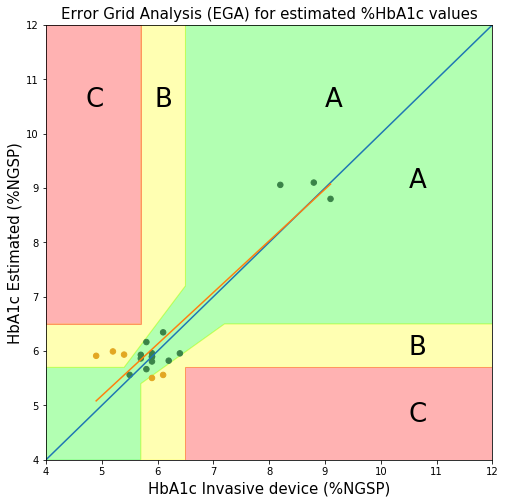

############ HbA1c Evaluation Metrics ############
Diff STD (full) =  0.42852232274930535
MSE (full) =  0.19742794548926346
ME (full) =  -0.11745877742767323
MAD (full) =  0.34539926052093506
RMSE (full) =  0.444328645812155
R2 score (full) =  0.8375880672184407
Pearson R and p-value:  (0.9265970887630828, 4.491678180903642e-09)
#################################################

############ SpO2 Evaluation Metrics ############
Diff STD (full) =  1.49386613151887
MSE (full) =  2.2329108518897556
ME (full) =  -0.03570480346679687
MAD (full) =  1.2054527282714844
RMSE (full) =  1.4942927597662232
Reference Closeness Factor (RCF):  0.9879454727172851
#################################################

HbA1c %CV precision metric: 
Maximum %CV:  6.8051763
Mean %CV:  1.633571


SpO2 %CV precision metric: 
Maximum %CV:  1.1587261
Mean %CV:  0.32119602


HbA1c Bland Altman Analysis: 
Mean:  -0.11745877742767323
+1.96 STD:  0.7224449751609653
-1.96 STD:  -0.9573625300163117
Bias:  -0.11745877742

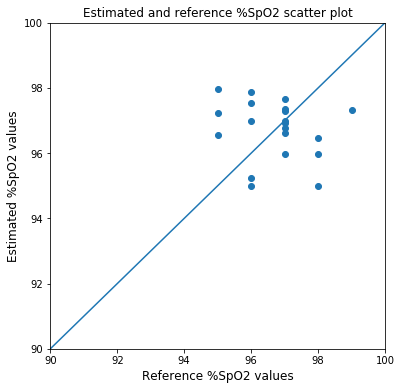

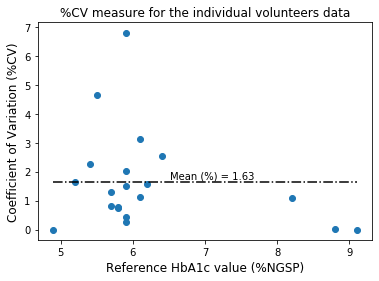

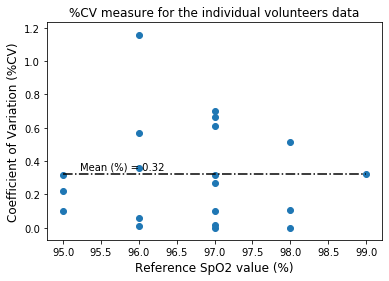

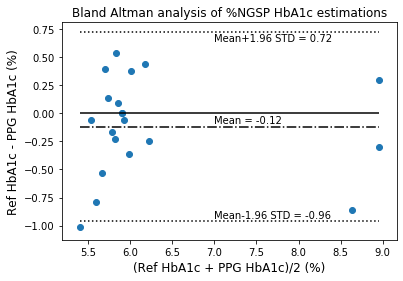

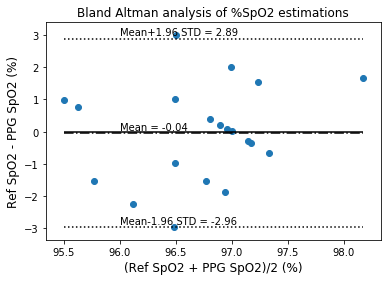

In [24]:
# Model 1 Results
print('PDT Refl Type Results')
EGA(resultshsR[:,0],resultshs[:,0])
evalMetricsH(resultshsR[:,0],resultshs[:,0])
Spo2Plot(resultshsR[:,1],resultshs[:,1])
evalMetricsS(resultshsR[:,1],resultshs[:,1])
print('HbA1c %CV precision metric: ')
CVplotHb(resultshsR[:,0],evrdat,indx=1)
print('SpO2 %CV precision metric: ')
CVplotSp(resultshsR[:,1],evrdat,indx=2)
print('HbA1c Bland Altman Analysis: ')
hBAA(resultshsR[:,0],resultshs[:,0])
print('SpO2 Bland Altman Analysis: ')
spBAA(resultshsR[:,1],resultshs[:,1],96)

# Photon Diffusion Transmission Type

PDT Tran Type Results


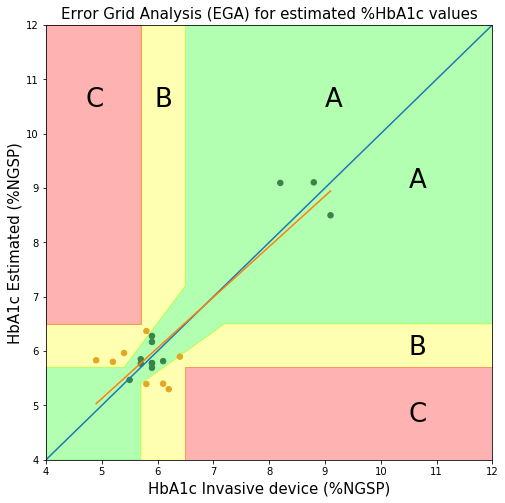

############ HbA1c Evaluation Metrics ############
Diff STD (full) =  0.5100139997111226
MSE (full) =  0.2619180785984954
ME (full) =  -0.0424711513519286
MAD (full) =  0.4302805137634277
RMSE (full) =  0.5117793260756978
R2 score (full) =  0.7845359669311488
Pearson R and p-value:  (0.8976052939411541, 8.061902230097382e-08)
#################################################

############ SpO2 Evaluation Metrics ############
Diff STD (full) =  1.507802881006295
MSE (full) =  2.3038384508457965
ME (full) =  -0.17426681518554688
MAD (full) =  1.2236480712890625
RMSE (full) =  1.5178400610228326
Reference Closeness Factor (RCF):  0.9877635192871095
#################################################

HbA1c %CV precision metric: 
Maximum %CV:  7.657071
Mean %CV:  2.0762832


SpO2 %CV precision metric: 
Maximum %CV:  0.8592909
Mean %CV:  0.36248776


HbA1c Bland Altman Analysis: 
Mean:  -0.0424711513519286
+1.96 STD:  0.9571562880818717
-1.96 STD:  -1.042098590785729
Bias:  -0.042471151351928

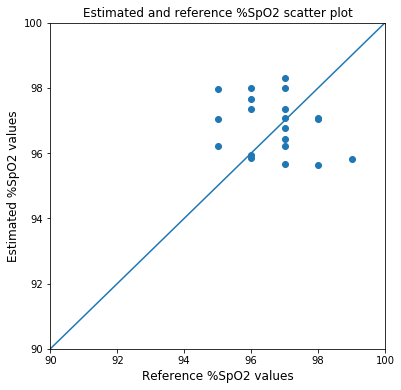

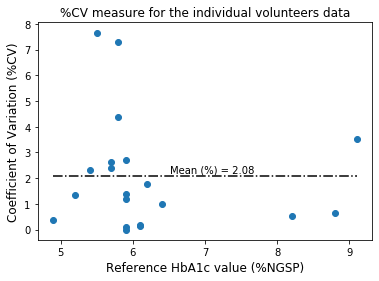

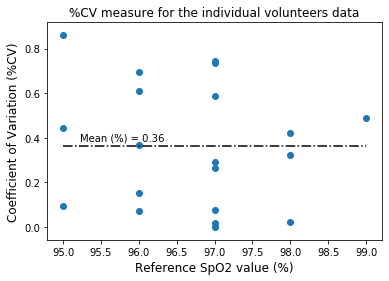

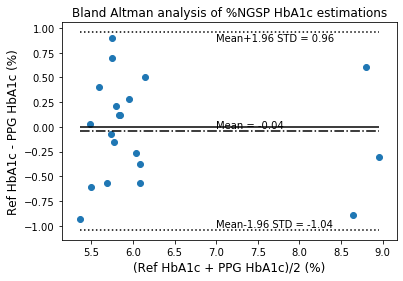

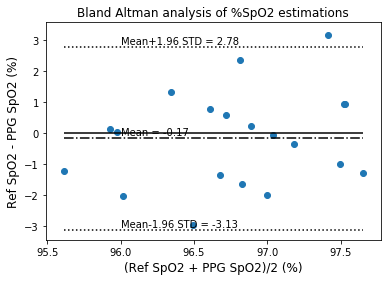

In [25]:
# Model 2 Results
print('PDT Tran Type Results')
EGA(resultshsR[:,0],resultshs[:,2])
evalMetricsH(resultshsR[:,0],resultshs[:,2])
Spo2Plot(resultshsR[:,1],resultshs[:,3])
evalMetricsS(resultshsR[:,1],resultshs[:,3])
print('HbA1c %CV precision metric: ')
CVplotHb(resultshsR[:,0],evrdat,indx=3)
print('SpO2 %CV precision metric: ')
CVplotSp(resultshsR[:,1],evrdat,indx=4)
print('HbA1c Bland Altman Analysis: ')
hBAA(resultshsR[:,0],resultshs[:,2])
print('SpO2 Bland Altman Analysis: ')
spBAA(resultshsR[:,1],resultshs[:,3],96)